# Loading cloud-free Landsat into one dataset

**What does this notebook do?** 

This notebook demonstrates how to use xarray functions to create a time series of cloud-free observations from Landsat 8, and then plot the data as a cloud-free time series animation with each frame annotated by satellite name.


This notebook is adapted from a Digital Earth Australia example by Robbi Bishop-Taylor

## Import modules and functions

In [1]:
%matplotlib inline
import os
import sys
import datacube
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
from datacube.utils import geometry
from datacube.utils.geometry import CRS
from datacube import Datacube
from datacube.storage import masking

# Import external functions from dea-notebooks using relative link to Scripts
#sys.path.append('../10_Scripts')
#import DEAPlotting
#import DEADataHandling

# Connect to datacube database
dc = datacube.Datacube(app='Time series animation')


/home/jovyan/.local/lib/python3.6/site-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)


## Set up analysis variables
This sets the analysis extent, time period, output resolution and minimum proportion of cloud-free pixels used to filter the observations.

In [2]:
# Set up centre of area to analyse, and a buffer in metres around this centrepoint
lat, lon, buffer_m = -35.3, 149.11, 9000

# Set range of time to return data from both Landsat and Sentinel 2
time_range = ('2017-01-01', '2018-01-01')

# Set the output resolution. 
resolution = (-30, 30)

# Set up minimum proportions of cloud-free pixels required to return Landsat. 
# A proportion of 0.95 means that only observations with less than 5% cloud will be returned.
landsat_cloud_free_prop = 0.98

### Load in Landsat /8 timeseries
Load in Landsat data for the centrepoint, buffer and time range specified above. 
    
The proportion of clear pixels is calculated by summing the pixels that are flagged as being problematic in the Landsat PQ layer. By default only cloudy or cloud shadowed pixels or pixels without valid data in every band are included in the calculation, but this can be customised using the `mask_dict` function.

<div class="alert alert-info">
<b>If you encounter memory issues:</b> By default, the function removes invalid -999 values by replacing them with NaN (<code>mask_invalid_data=True</code>). For large data extractions, it is recommended that you set both <code>mask_pixel_quality=False</code> and <code>mask_invalid_data=False</code>. Otherwise, all output variables will be coerced to float64 when NaN values are inserted into the array, potentially causing your data to use 4x as much memory. Be aware that the resulting arrays will contain invalid -999 values which should be considered in analyses.
</div>

In [3]:
# Set up analysis data query using a buffer around a lat-long point (1280 x 720).
# This simply converts a lat long to Australian Albers, then creates a square analysis region
# by creating a square buffer around the point.
x, y = geometry.point(lon, lat, CRS('WGS84')).to_crs(CRS('EPSG:3577')).points[0]
query = {'x': (x - buffer_m, x + buffer_m),
         'y': (y - buffer_m, y + buffer_m),    
         'time': time_range,
         'crs': 'EPSG:3577',
         'output_crs': 'EPSG:3577',
         'resolution': resolution} 

In [4]:
# Load data - we will use dask_chunks to lazily load the data by timeslice. There could be a lot of data and lazy loading with
# dask will help with memory management
ds = dc.load(product='ls8_usgs_sr_scene', group_by='solar_day', **query, dask_chunks={'time': 1})
ds

<xarray.Dataset>
Dimensions:          (time: 16, x: 601, y: 601)
Coordinates:
  * time             (time) datetime64[ns] 2017-09-04T23:50:24.564670 ...
  * y                (y) float64 -3.95e+06 -3.95e+06 -3.95e+06 -3.95e+06 ...
  * x                (x) float64 1.539e+06 1.539e+06 1.54e+06 1.54e+06 ...
Data variables:
    coastal_aerosol  (time, y, x) int16 dask.array<shape=(16, 601, 601), chunksize=(1, 601, 601)>
    blue             (time, y, x) int16 dask.array<shape=(16, 601, 601), chunksize=(1, 601, 601)>
    green            (time, y, x) int16 dask.array<shape=(16, 601, 601), chunksize=(1, 601, 601)>
    red              (time, y, x) int16 dask.array<shape=(16, 601, 601), chunksize=(1, 601, 601)>
    nir              (time, y, x) int16 dask.array<shape=(16, 601, 601), chunksize=(1, 601, 601)>
    swir1            (time, y, x) int16 dask.array<shape=(16, 601, 601), chunksize=(1, 601, 601)>
    swir2            (time, y, x) int16 dask.array<shape=(16, 601, 601), chunksize=(1, 601, 

Dask - Memory - what???

Xarray, which open datacube uses for its arrays, has a connection with another python project called Dask. Dask implements distributed xarray processing on clusters of computers. Whilst this notebook doesn't use that dask has another trick, it can work on arrays that are larger than available memory and only load the parts you are currently working on. It does this by loading in smaller chunks of data. When `dc.load` specified `dask_chunks` with `time: 1` it said to work in chunks that are 1 time slice is size. The xarray output above has changed accordingly, the `Dataset` shows 16 time slices of 601x601 in size. The `Data variables` no longer show the array values, but the dask structure - `chunksize` 1 time slice, out of 16.

Why no data?

Because Dask doesn't load the data until we actually want it loaded. The moment we access one of those Data Variables dask will go get the appropriate data in chunks. You probably noticed this was REALLY fast, now you know why. It did practically nothing. Later when you go to use it the actual load will occur, you can't avoid the inevitable.

## Construct the cloud mask

As before, lets construct a cloud mask for this data using the PQ data. We can can the simply count the number of cloud free observations in the region, divide it by the number of pixels to give us a cloud free percentage for that time slice.

To do this we use two `xarray` functions:
`xarray.sum(dim.. )` - This will sum up all the array values along the dimensions specified. Since our array is filled with 1 and 0 (True and False) and we asked for both `x` and `y` dimensions this will give us the total number of cloud free pixels
`xarray.shape[]` - `shape` is literarrly the shape of the array, time, x and y. so in this case its 16, 601, 601 as you saw in the output above. We'll grab just the x and y figures to give us the total number of pixels in an timeslice.

divide these to get the cloud free percentage.

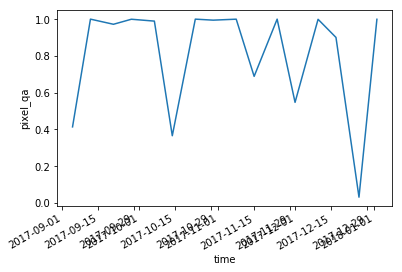

In [5]:
# first create the cloud mask, this will do all time slices
cloud_mask = masking.make_mask(ds.pixel_qa, cloud='no_cloud', cloud_shadow='no_cloud_shadow') 

# Now calculate the cloud free percentage
cloud_free_percentage = cloud_mask.sum(dim=['x', 'y']) / (cloud_mask.shape[1] * cloud_mask.shape[2])

# The result is an array of percentages, lets use the builtin plot function to display it as a graph
# Note: this will take a moment as this will cause dask to actually load and compute on the data required, the full PQ layers
# in this case. Values will be 0.0 - 1.0 of course.
cloud_free_percentage.plot()


The most useful place for cloud percentage is with our original dataset. It's a single value per time slice, so lets add it back as a `Data variable` and give it a `time` coordinate. The timestamp is the same as the original observations so we can construct a `DataArray` with both the values and coordinates by copying those in

In [6]:
ds['cloud_free_percentage'] = xr.DataArray(cloud_free_percentage, [('time', ds.time)])
ds

<xarray.Dataset>
Dimensions:                (time: 16, x: 601, y: 601)
Coordinates:
  * time                   (time) datetime64[ns] 2017-09-04T23:50:24.564670 ...
  * y                      (y) float64 -3.95e+06 -3.95e+06 -3.95e+06 ...
  * x                      (x) float64 1.539e+06 1.539e+06 1.54e+06 1.54e+06 ...
Data variables:
    coastal_aerosol        (time, y, x) int16 dask.array<shape=(16, 601, 601), chunksize=(1, 601, 601)>
    blue                   (time, y, x) int16 dask.array<shape=(16, 601, 601), chunksize=(1, 601, 601)>
    green                  (time, y, x) int16 dask.array<shape=(16, 601, 601), chunksize=(1, 601, 601)>
    red                    (time, y, x) int16 dask.array<shape=(16, 601, 601), chunksize=(1, 601, 601)>
    nir                    (time, y, x) int16 dask.array<shape=(16, 601, 601), chunksize=(1, 601, 601)>
    swir1                  (time, y, x) int16 dask.array<shape=(16, 601, 601), chunksize=(1, 601, 601)>
    swir2                  (time, y, x) in

At this point then we have a single `Dataset` `ds` containing all our Landsat `measurements` and a newly computed `cloud_free_percentage` for every time slice.

What we want is _only_ the timeslices that meet our cloud free threshold. We can use an `xarray` selection to do this.




In [7]:
# landsat_cloud_free_prop was defined way back at the beginning to be our cloud free proportion (0.98 for the default notebook)
filtered = ds.sel(time=ds.cloud_free_percentage >= landsat_cloud_free_prop)
filtered

<xarray.Dataset>
Dimensions:                (time: 9, x: 601, y: 601)
Coordinates:
  * time                   (time) datetime64[ns] 2017-09-11T23:56:35.244378 ...
  * y                      (y) float64 -3.95e+06 -3.95e+06 -3.95e+06 ...
  * x                      (x) float64 1.539e+06 1.539e+06 1.54e+06 1.54e+06 ...
Data variables:
    coastal_aerosol        (time, y, x) int16 dask.array<shape=(9, 601, 601), chunksize=(1, 601, 601)>
    blue                   (time, y, x) int16 dask.array<shape=(9, 601, 601), chunksize=(1, 601, 601)>
    green                  (time, y, x) int16 dask.array<shape=(9, 601, 601), chunksize=(1, 601, 601)>
    red                    (time, y, x) int16 dask.array<shape=(9, 601, 601), chunksize=(1, 601, 601)>
    nir                    (time, y, x) int16 dask.array<shape=(9, 601, 601), chunksize=(1, 601, 601)>
    swir1                  (time, y, x) int16 dask.array<shape=(9, 601, 601), chunksize=(1, 601, 601)>
    swir2                  (time, y, x) int16 das

You'll notice we went from 16 timeslices to 9 meeting the criteria. Looking at the earlier graph that seems about right.
At the moment we can't see all the data because dask is doing its job. We have less data now and it will probably fit in memory so let's force dask to load it all so we can see real observations.

In [8]:
# Get dask to load all the data up
filtered = filtered.compute()

## Memory management

At this point we have several variables that we no longer need, chewing up memory (though dask is helping). From this point on we only need our `filtered` datasets so lets set the old ones to None and the will free up memory and close of any files dask is track too.

In [9]:
ds = None
cloud_free_percentage = None
cloud_mask = None

# Display the result
Not lets plot the result like we usually do, taking care to remove all the invalid data first. This has been covered in several other notebooks so lets just do it.

<xarray.Dataset>
Dimensions:                (time: 9, x: 601, y: 601)
Coordinates:
  * time                   (time) datetime64[ns] 2017-09-11T23:56:35.244378 ...
  * y                      (y) float64 -3.95e+06 -3.95e+06 -3.95e+06 ...
  * x                      (x) float64 1.539e+06 1.539e+06 1.54e+06 1.54e+06 ...
Data variables:
    coastal_aerosol        (time, y, x) float64 536.0 591.0 579.0 582.0 ...
    blue                   (time, y, x) float64 671.0 709.0 734.0 736.0 ...
    green                  (time, y, x) float64 1.004e+03 1.066e+03 ...
    red                    (time, y, x) float64 1.178e+03 1.24e+03 1.306e+03 ...
    nir                    (time, y, x) float64 2.954e+03 2.869e+03 ...
    swir1                  (time, y, x) float64 3.153e+03 3.095e+03 ...
    swir2                  (time, y, x) float64 2.065e+03 2.139e+03 ...
    pixel_qa               (time, y, x) uint16 322 322 322 322 322 322 322 ...
    sr_aerosol             (time, y, x) uint8 96 96 96 96 96 96 96 

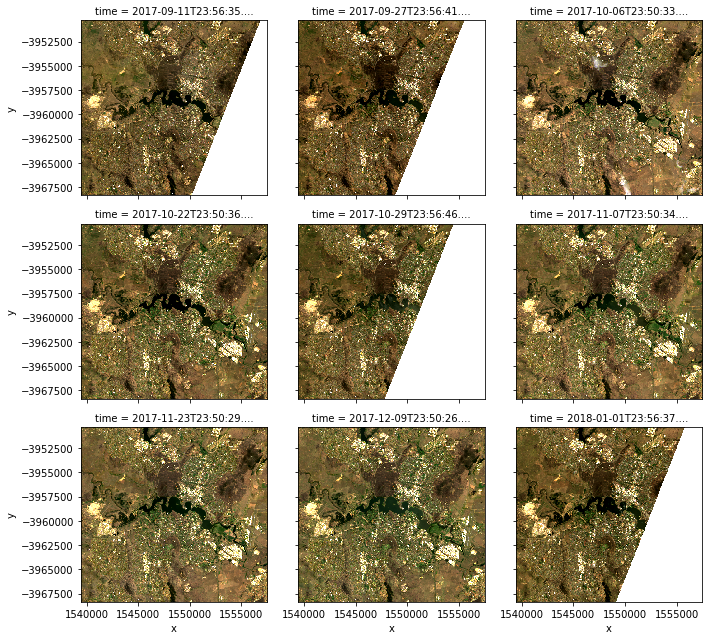

In [10]:
# Get the measurements from the datacube
measurements = dc.list_measurements()
reflectance_measurements = measurements[measurements['units'] == 'reflectance']
dv_names = reflectance_measurements.index.get_level_values('measurement')

# Set all nodata pixels to `NaN` for the data variables in dv_names
filtered_nans = masking.mask_invalid_data(filtered[dv_names])
# Set all invalid to `NaN` - valid range for USRS SR is 0 to 10000
filtered_nans = filtered_nans.where((filtered_nans >= 0) & (filtered_nans<=10000))

filtered.update(filtered_nans)
filtered_nans = None # clean up memory

# Print and plot resulting data
# Use a few parameters to control how much we display, time= range, restricts to timeslices 0 to 8 inclusive (all of them unles you changed the data)
# col_wrap = 3 will cause the time column to wrap. These parameters are optional but keep the notebook tidy
print(filtered)
filtered[['red', 'green', 'blue']].isel(time=range(0, 9)).to_array().plot.imshow(robust=True, col='time', col_wrap=3)

In [22]:
from skimage import exposure
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib.patheffects as PathEffects
from datetime import datetime
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import calendar
from matplotlib.colors import ListedColormap
from mpl_toolkits.axes_grid1 import make_axes_locatable


def animated_timeseries(ds, output_path, width_pixels=600, interval=200, 
                        bands=['red', 'green', 'blue'], percentile_stretch = (0.02, 0.98),
                        title=False, show_date=True, annotation_kwargs={},
                        time_dim = 'time', x_dim = 'x', y_dim = 'y'):
    
    """
    Takes an xarray time series and animates the data as a three-band (e.g. true or false colour) 
    animation, allowing changes in the landscape to be compared across time.
    
    Animations can be exported as .mp4 (ideal for Twitter/social media), .wmv (ideal for Powerpoint) and .gif 
    (ideal for all purposes, but can have large file sizes) format files, and customised to include titles and 
    date annotations or use specific combinations of input bands.  
    
    Modified from the work of: Robbi Bishop-Taylor, Sean Chua, Bex Dunn    
    
    :param ds: 
        An xarray dataset with multiple time steps (i.e. multiple observations along the `time` dimension).
        
    :param output_path: 
        A string giving the output location and filename of the resulting animation. File extensions of '.mp4', 
        '.wmv' and '.gif' are accepted.
    
    :param width_pixels:
        An integer defining the output width in pixels for the resulting animation. The height of the animation is
        set automatically based on the dimensions/ratio of the input xarray dataset. Defaults to 600 pixels wide.
        
    :param interval:
        An integer defining the milliseconds between each animation frame used to control the speed of the output
        animation. Higher values result in a slower animation. Defaults to 200 milliseconds between each frame. 
        
    :param bands:
        An optional list of either one or three bands to be plotted, all of which must exist in `ds`.
        Defaults to `['red', 'green', 'blue']`. 
        
    :param percentile_stretch:
        An optional tuple of two floats that can be used to clip one or three-band arrays by percentiles to produce 
        a more vibrant, visually attractive image that is not affected by outliers/extreme values. The default is 
        `(0.02, 0.98)` which is equivalent to xarray's `robust=True`.

    :param title: 
        An optional string or list of strings with a length equal to the number of timesteps in ds. This can be
        used to display a static title (using a string), or a dynamic title (using a list) that displays different
        text for each timestep. Defaults to False, which plots no title.
        
    :param show_date:
        An optional boolean that defines whether or not to plot date annotations for each animation frame. Defaults 
        to True, which plots date annotations based on ds.
        
    :param annotation_kwargs:
        An optional dict of kwargs for controlling the appearance of text annotations to pass to the matplotlib 
        `plt.annotate` function (see https://matplotlib.org/api/_as_gen/matplotlib.pyplot.annotate.html for options). 
        For example, `annotation_kwargs={'fontsize':20, 'color':'red', 'family':'serif'}. By default, text annotations 
        are plotted as white, size 25 mono-spaced font with a 4pt black outline in the top-right of the animation.   
        
    :param time_dim:
        An optional string allowing you to override the xarray dimension used for time. Defaults to 'time'.
    
    :param x_dim:
        An optional string allowing you to override the xarray dimension used for x coordinates. Defaults to 'x'.
    
    :param y_dim:
        An optional string allowing you to override the xarray dimension used for y coordinates. Defaults to 'y'.       
    """
       
    # Define function to convert xarray dataset to list three band numpy arrays
    def _ds_to_arrraylist(ds, bands, time_dim, x_dim, y_dim, percentile_stretch): 
        
        """
        Converts an xarray dataset to a list of numpy arrays for plt.imshow plotting
        """
        
        # Compute percents
        p_low, p_high = ds[bands].to_array().quantile(percentile_stretch).values

        array_list = []
        for i, timestep in enumerate(ds[time_dim]):

            # Select single timestep from the data array
            ds_i = ds[{time_dim: i}]

            # Get shape of array
            x = len(ds[x_dim])
            y = len(ds[y_dim])

            # Create new three band array                
            rawimg = np.zeros((y, x, 3), dtype=np.float32)

            # Add xarray bands into three dimensional numpy array
            for band, colour in enumerate(bands):

                rawimg[:, :, band] = ds_i[colour].values

            # Stretch contrast using percentile values
            img_toshow = exposure.rescale_intensity(rawimg, in_range=(p_low, p_high))

            array_list.append(img_toshow)
            
        return array_list, p_low, p_high
    
   
    ###############
    # Setup steps #
    ############### 

    # Test if all dimensions exist in dataset
    if time_dim in ds and x_dim in ds and y_dim in ds:        
        
        # First test if there are three bands, and that all exist in both datasets:
        if (len(bands) == 3) & all([(b in ds.data_vars) for b in bands]): 

            # Import xarrays as lists of three band numpy arrays
            imagelist, vmin, vmax = _ds_to_arrraylist(ds, bands=bands, 
                                                      time_dim=time_dim, x_dim=x_dim, y_dim=y_dim, 
                                                      percentile_stretch=percentile_stretch)
        
            # Get time, x and y dimensions of dataset and calculate width vs height of plot
            timesteps = len(ds[time_dim])    
            width = len(ds[x_dim])
            height = len(ds[y_dim])
            width_ratio = float(width) / float(height)
            height = 10.0 / width_ratio

            # If title is supplied as a string, multiply out to a list with one string per timestep.
            # Otherwise, use supplied list for plot titles.
            if isinstance(title, str) or isinstance(title, bool):
                title_list = [title] * timesteps 
            else:
                title_list = title

            # Set up annotation parameters that control font etc. The nested dict structure sets default 
            # values which can be overwritten/customised by the manually specified `annotation_kwargs`
            annotation_kwargs = dict({'xy': (1, 1), 'xycoords':'axes fraction', 
                                      'xytext':(-5, -5), 'textcoords':'offset points', 
                                      'horizontalalignment':'right', 'verticalalignment':'top', 
                                      'fontsize':25, 'color':'white', 
                                      'path_effects':[PathEffects.withStroke(linewidth=4, foreground='black')]},
                                      **annotation_kwargs)

            ###################
            # Initialise plot #
            ################### 
            
            # Set up figure
            fig, ax1 = plt.subplots(ncols=1) 
            fig.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0, hspace=0)
            fig.set_size_inches(10.0, height, forward=True)
            ax1.axis('off')

            # Initialise axesimage objects to be updated during animation, setting extent from dims
            extents = [float(ds[x_dim].min()), float(ds[x_dim].max()), 
                       float(ds[y_dim].min()), float(ds[y_dim].max())]
            im = ax1.imshow(imagelist[0], extent=extents)

            # Initialise annotation objects to be updated during animation
            t = ax1.annotate('', **annotation_kwargs) 
    

            ########################################
            # Create function to update each frame #
            ########################################

            # Function to update figure
            def update_figure(frame_i):            
            
                # If possible, extract dates from time dimension
                try:

                    # Get human-readable date info (e.g. "16 May 1990")
                    ts = ds[time_dim][{time_dim:frame_i}].dt
                    year = ts.year.item()
                    month = ts.month.item()
                    day = ts.day.item()
                    date_string = '{} {} {}'.format(day, calendar.month_abbr[month], year)
                    
                except:
                    
                    date_string = ds[time_dim][{time_dim:frame_i}].values.item()

                # Create annotation string based on title and date specifications:
                title = title_list[frame_i]
                if title and show_date:
                    title_date = '{}\n{}'.format(date_string, title)
                elif title and not show_date:
                    title_date = '{}'.format(title)
                elif show_date and not title:
                    title_date = '{}'.format(date_string)           
                else:
                    title_date = ''

                # Update figure for frame
                im.set_array(imagelist[frame_i])
                t.set_text(title_date) 

                # Return the artists set
                return [im, t]


            ##############################
            # Generate and run animation #
            ##############################

            # Generate animation
            print('Generating {} frame animation'.format(timesteps))
            ani = animation.FuncAnimation(fig, update_figure, frames=timesteps, interval=interval, blit=True)

            # Export as either MP4 or GIF
            if output_path[-3:] == 'mp4':
                print('    Exporting animation to {}'.format(output_path))
                ani.save(output_path, dpi=width_pixels / 10.0)

            elif output_path[-3:] == 'wmv':
                print('    Exporting animation to {}'.format(output_path))
                ani.save(output_path, dpi=width_pixels / 10.0, 
                         writer=animation.FFMpegFileWriter(fps=1000 / interval, bitrate=4000, codec='wmv2'))

            elif output_path[-3:] == 'gif':
                print('    Exporting animation to {}'.format(output_path))
                ani.save(output_path, dpi=width_pixels / 10.0, writer='imagemagick')

            else:
                print('    Output file type must be either .mp4, .wmv or .gif')
                
            return ani

        else:        
            print('Please select three bands that all exist in the input dataset')  

    else:
        print('At least one x, y or time dimension does not exist in the input dataset. Please use the `time_dim`,' \
              '`x_dim` or `y_dim` parameters to override the default dimension names used for plotting') 


MovieWriter imagemagick unavailable. Trying to use pillow instead.


Generating 9 frame animation
    Exporting animation to /home/jovyan/output/cloud_free_landsat.gif


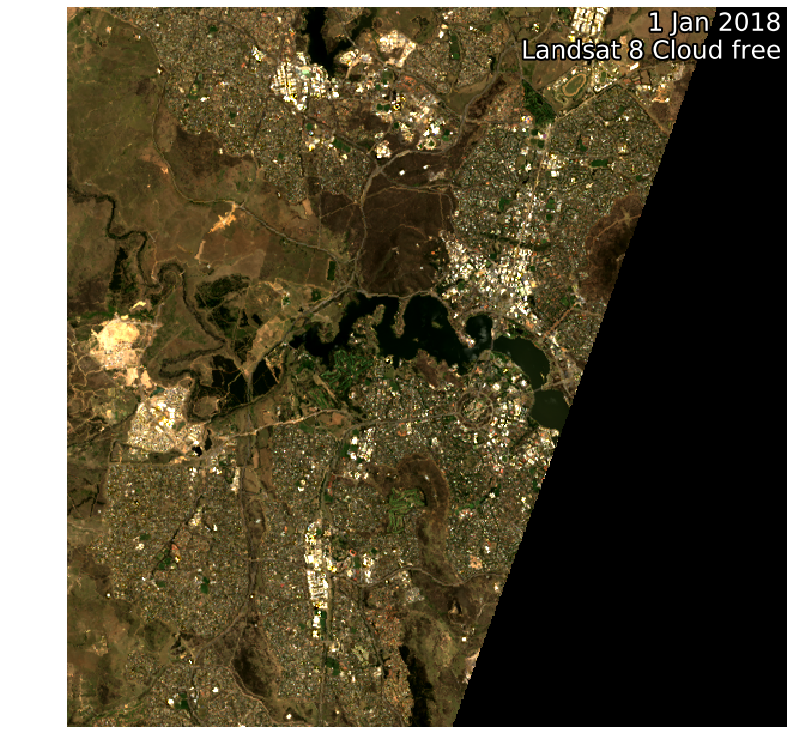

In [23]:
# Produce an RGB animation that includes both Sentinel and Landsat observations, using
# the `title` parameter to print the name of the dataset
animation = animated_timeseries(ds=filtered,
                                output_path='/home/jovyan/output/cloud_free_landsat.gif', 
                                bands=['red', 'green', 'blue'], 
                                interval=200,
                                width_pixels=500,
                                title='Landsat 8 Cloud free',
                                percentile_stretch=[0.01, 0.99])

In [24]:
# Let's make the animation playback in the jupyter notebook
from IPython.display import HTML
HTML(animation.to_html5_video())
